In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional,InputLayer
from sklearn.model_selection import train_test_split

In [12]:
data_path  = "/content/preprocessed_data.csv"
df = pd.read_csv(data_path,names=['text','job_category'],encoding = "ISO-8859-1")

In [13]:
df

,text,job_category
0,an experienced hr professional hr mentor coach...,hr
1,head talent acquisition hr leader strategic pa...,hr
2,a talent acquisition hr professional experienc...,hr
3,over 18 years experience it ites bpo leading g...,hr
4,human resources business partner demonstrated ...,hr
...,...,...
665,experienced aircraft maintenance engineer demo...,aviation
666,aerobusiness professional independent consulta...,aviation
667,i ritu royborn india energeticambitious young ...,aviation
668,an mba graduate specialized aviation managemen...,aviation


In [15]:
d = {'job_category':df['job_category'].value_counts().index, 'count': df['job_category'].value_counts()}
df_cat = pd.DataFrame(data=d).reset_index(drop=True)
df_cat

,job_category,count
0,public relations,41
1,health & fitness,40
2,digital media,38
3,engineering,36
4,business development,36
5,consultant,36
6,sales,35
7,hr,34
8,information technology,28
9,food & beverages,28


Text(0.5, 0, '类目')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31867 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 30446 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24067 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 31867 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 30446 missing from current font.
  font.set_te

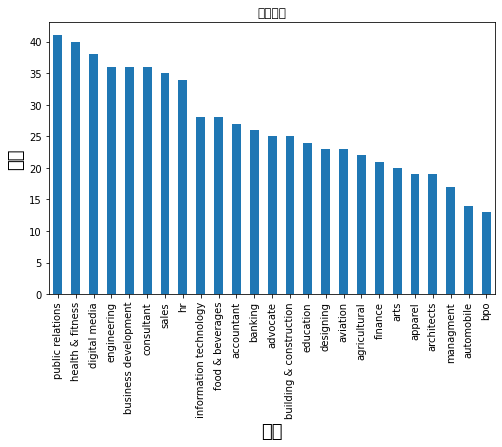

In [19]:
df_cat.plot(x='job_category', y='count', kind='bar', legend=False,  figsize=(8, 5))
plt.title("类目分布")
plt.ylabel('数量', fontsize=18)
plt.xlabel('类目', fontsize=18)

In [23]:
df['cat_id'] = df['job_category'].factorize()[0]
cat_id_df = df[['job_category', 'cat_id']].drop_duplicates().sort_values('cat_id').reset_index(drop=True)
cat_to_id = dict(cat_id_df.values)
id_to_cat = dict(cat_id_df[['cat_id', 'job_category']].values)
df.sample(10)

,text,job_category,cat_id
403,experienced senior design engineer demonstrate...,engineering,15
91,digital ecommerce information technology it le...,information technology,3
250,i am in call center industry for the last 29 y...,bpo,9
109,experienced information technology manager dem...,education,4
22,human resources leader 18 years experience ind...,hr,0
100,founder librarianship studies information tech...,information technology,3
660,aviation management,aviation,24
578,manuel currently involved relocation luton tow...,architects,21
665,experienced aircraft maintenance engineer demo...,aviation,24
448,our product range comprises water chemical pum...,engineering,15


In [41]:
MAX_NB_WORDS = 500
# 每条cut_review最大的长度
MAX_SEQUENCE_LENGTH = 250
# 设置Embeddingceng层的维度
EMBEDDING_DIM = 100
 
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index


In [32]:
from keras.preprocessing.sequence import pad_sequences

In [42]:
X = tokenizer.texts_to_sequences(df['text'].values)
#填充X,让X的各个列的长度统一
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
 
#多类标签的onehot展开
Y = pd.get_dummies(df['cat_id']).values
 
print(X.shape)
print(Y.shape)

(670, 250)
(670, 25)


In [43]:
#拆分训练集和测试集
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(603, 250) (603, 25)
(67, 250) (67, 25)


In [44]:
#定义模型
model = keras.models.Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(25, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 100)          50000     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
Total params: 132,925
Trainable params: 132,925
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Epoch 1/5
9/9 [==============================] - 11s 808ms/step - loss: 3.2142 - accuracy: 0.0738 - val_loss: 3.1988 - val_accuracy: 0.0656
Epoch 2/5
9/9 [==============================] - 7s 759ms/step - loss: 3.1804 - accuracy: 0.1033 - val_loss: 3.1730 - val_accuracy: 0.0820
Epoch 3/5
9/9 [==============================] - 7s 748ms/step - loss: 3.1475 - accuracy: 0.1365 - val_loss: 3.1462 - val_accuracy: 0.1639
Epoch 4/5
9/9 [==============================] - 7s 752ms/step - loss: 3.0940 - accuracy: 0.1421 - val_loss: 3.0902 - val_accuracy: 0.1148
Epoch 5/5
9/9 [==============================] - 7s 756ms/step - loss: 3.0294 - accuracy: 0.1679 - val_loss: 3.0428 - val_accuracy: 0.0656
